# DAVI (deep approximate value iteration) trained with increasing distance

## Download data

In [1]:
!wget https://transfer.sh/G97F1/data.zip
!unzip data.zip -d data

--2019-08-21 19:43:09--  https://transfer.sh/G97F1/data.zip
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6912815 (6.6M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   6.59M  6.51MB/s    in 1.0s    

2019-08-21 19:43:15 (6.51 MB/s) - ‘data.zip’ saved [6912815/6912815]

Archive:  data.zip
 extracting: data/actions_test.pkl.gz  
 extracting: data/actions_train.pkl.gz  
 extracting: data/distances_test.pkl.gz  
  inflating: data/distances_train.pkl.gz  
  inflating: data/room_structures_test.pkl.gz  
  inflating: data/room_structures_train.pkl.gz  
  inflating: data/states_test.pkl.gz  
  inflating: data/states_train.pkl.gz  


## Check System info

In [2]:
!nvidia-smi

Wed Aug 21 19:43:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Load data

In [0]:
import gzip
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def create_dataloader(batch_size, dataset_type='train', max_steps=1):
    class SokobanDataset(Dataset):
        def __init__(self, room_structures, states, distances, max_steps=1):
            self.data = []
            self.target = []

            for state, room_structure, distance in zip(states, room_structures, distances):
                if distance <= max_steps:
                    wall_map = torch.from_numpy((state == 0).astype(int)).flatten()
                    target_map = torch.from_numpy((room_structure == 2).astype(int)).flatten()
                    boxes_map = torch.from_numpy(((state == 3) | (state == 4)).astype(int)).flatten()
                    agent_map = torch.from_numpy((state == 5).astype(int)).flatten()

                    self.data.append(torch.cat((wall_map, target_map, boxes_map, agent_map), 0))
                    self.target.append(distance)

        def __len__(self):
            return len(self.target)

        def __getitem__(self, idx):
            return self.data[idx], self.target[idx]

    with gzip.open(f'data/room_structures_{dataset_type}.pkl.gz', 'rb') as f:
        room_structures = pickle.load(f)

    with gzip.open(f'data/states_{dataset_type}.pkl.gz', 'rb') as f:
        states = pickle.load(f)

    with gzip.open(f'data/distances_{dataset_type}.pkl.gz', 'rb') as f:
        distances = pickle.load(f)

    sokoban_dataset = SokobanDataset(room_structures, states, distances, max_steps)
    print('sokoban_dataset =', len(sokoban_dataset))

    return DataLoader(sokoban_dataset, shuffle=True, batch_size=batch_size)


def plot_distribution():
    with gzip.open('data/distances_train.pkl.gz', 'rb') as f:
        distances = pickle.load(f)

    stats = {}
    for distance in distances:
        if distance in stats:
            stats[distance] += 1
        else:
            stats[distance] = 1
    print('train', stats)
    plt.bar(range(len(stats)), list(stats.values()), align='center', label='train data')
    plt.xticks(range(len(stats)), list(stats.keys()))

    with gzip.open('data/distances_test.pkl.gz', 'rb') as f:
        distances = pickle.load(f)

    stats = {}
    for distance in distances:
        if distance in stats:
            stats[distance] += 1
        else:
            stats[distance] = 1
    print('test', stats)
    plt.bar(range(len(stats)), list(stats.values()), align='center', label='test data')

    plt.xlabel('steps to solution')
    plt.ylabel('# examples')
    plt.legend()
    plt.show()


def create_model():
    class ResidualBlock(nn.Module):
        expansion = 1

        def __init__(self, num_features):
            super(ResidualBlock, self).__init__()

            self.fc1 = nn.Linear(num_features, num_features)
            self.bn1 = nn.BatchNorm1d(num_features)
            self.relu = nn.ReLU(inplace=True)
            self.fc2 = nn.Linear(num_features, num_features)
            self.bn2 = nn.BatchNorm1d(num_features)

        def forward(self, x):
            identity = x

            out = self.fc1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.fc2(out)
            out = self.bn2(out)

            out += identity

            return self.relu(out)

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            self.model = nn.Sequential(
                nn.Linear(400, 5000),
                nn.BatchNorm1d(5000),
                nn.ReLU(),

                nn.Linear(5000, 1000),
                nn.BatchNorm1d(1000),
                nn.ReLU(),

                ResidualBlock(1000),
                ResidualBlock(1000),
                ResidualBlock(1000),
                ResidualBlock(1000),

                nn.Linear(1000, 1)
            )

        def forward(self, x):
            return self.model(x)

    return Net()

### Plot data distribution

train {0: 29868, 1: 29868, 2: 29868, 3: 29868, 4: 29842, 5: 29797, 6: 29727, 7: 29632, 8: 29541, 9: 29425, 10: 29294, 11: 29177, 12: 29035, 13: 28904, 14: 28766, 15: 28622, 16: 28454, 17: 28280, 18: 28103, 19: 27876, 20: 27640, 21: 27316, 22: 26922, 23: 26357, 24: 25605, 25: 24495, 26: 23019, 27: 20191, 28: 14812}
test {0: 4187, 1: 4187, 2: 4187, 3: 4187, 4: 4182, 5: 4178, 6: 4172, 7: 4160, 8: 4147, 9: 4127, 10: 4111, 11: 4086, 12: 4068, 13: 4051, 14: 4037, 15: 4013, 16: 3987, 17: 3959, 18: 3942, 19: 3905, 20: 3867, 21: 3822, 22: 3765, 23: 3693, 24: 3597, 25: 3434, 26: 3197, 27: 2801, 28: 2071}


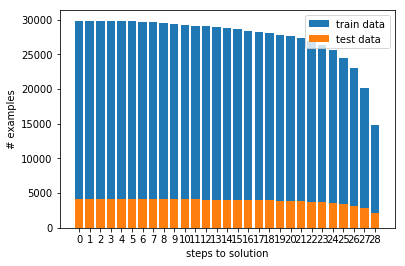

In [6]:
plot_distribution()

### Create model

In [0]:
model = create_model().to(device)
summary(model, (400,))

### Create Data Loader

In [0]:
batch_size = 128
data_loader_train = create_dataloader(batch_size, 'train', 1)
data_loader_test = create_dataloader(batch_size, 'test', 1)

sokoban_dataset = 59736
sokoban_dataset = 8374


## Train model

In [0]:
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [ ]:
from tqdm import tnrange, tqdm_notebook

def train_loop(loops):
    hold_train_loss = []
    hold_test_loss = []
    
    for loop_num in tqdm_notebook(loops ,desc='Loops'):
        batch_size = 128
        data_loader_train = create_dataloader(batch_size, 'train', loop_num)
        data_loader_test = create_dataloader(batch_size, 'test', loop_num)



        epochs = 10


        fx, tr_y = None, None
        for epoch in tnrange(epochs, desc='Epoch'):
            train_loss = []
            test_loss = []
            for batch_idx, (data, target) in enumerate(data_loader_train):
                tr_x, tr_y = data.float().to(device), target.float().to(device)

                # Reset gradient
                optimizer.zero_grad()

                # Forward pass
                fx = model(tr_x)
                output = loss(fx, tr_y.view(-1, 1))  # loss for this batch
                train_loss.append( output.detach().cpu().numpy())

                # Backward
                output.backward()

                # Update parameters based on backprop
                optimizer.step()

            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(data_loader_test):
                    tr_x, tr_y = data.float().to(device), target.float().to(device)
                    fx = model(tr_x)
                    test_loss.append(loss(fx, tr_y.view(-1, 1)).detach().cpu().numpy())  # loss for this batch

            hold_train_loss.append(np.mean(train_loss))
            hold_test_loss.append(np.mean(test_loss))
            print(hold_train_loss[-1], hold_test_loss[-1])
            
    plt.plot(np.array(hold_train_loss), label='train')
    plt.plot(np.array(hold_test_loss), label='test')
    plt.legend()
    plt.show()

sokoban_dataset = 59736
sokoban_dataset = 8374


0.009962827 6.219172e-05
9.791904e-05 3.9190938e-05
0.00014198756 0.00012001947
7.9488294e-05 5.5925444e-05
3.519727e-05 2.6797194e-05
2.2383801e-05 9.166025e-06
3.5742258e-05 1.3387495e-05
2.3483582e-05 2.8716604e-05
6.989125e-05 7.316947e-05
0.0009035261 7.9429265e-05
sokoban_dataset = 89604
sokoban_dataset = 12561


0.14818959 0.035730503
0.0074246647 0.009892529
0.0012925675 0.0025165342
0.00078633765 0.0062254956
0.0032132883 0.039113656
0.020074146 0.01731049
0.008257677 0.00462059
0.0024367296 0.0014840101
0.0022214504 0.0057926197
0.002558013 0.008052607
sokoban_dataset = 119472
sokoban_dataset = 16748


0.19120589 0.034648642
0.023604479 0.021488288
0.013585111 0.013690727
0.010640257 0.016789427
0.0073235086 0.010795349
0.006778358 0.01633767
0.004943723 0.008458655
0.0058055148 0.007213842
0.004358269 0.004709722
0.003488735 0.0025546523
sokoban_dataset = 149314
sokoban_dataset = 20930


0.3059135 0.22892484
0.20083909 0.18952648
0.16325772 0.17086916
0.13912226 0.17042133
0.122696534 0.16233137
0.107938685 0.1646524
0.09467998 0.16583672
0.08342997 0.16967683
0.07398862 0.17103256
0.06753068 0.18254304


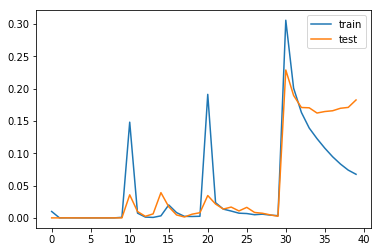

In [0]:
train_loop(range(1, 5))

sokoban_dataset = 208838
sokoban_dataset = 29280


1.0656221 0.99463964
0.8924872 0.9484317
0.80248517 0.9246414
0.7345869 0.8914061
0.6718093 0.89073527
0.6195817 0.89383215
0.57309425 0.8918161
0.53037757 0.9009069
0.4924255 0.8956839
0.4547992 0.897462
sokoban_dataset = 238470
sokoban_dataset = 33440


1.2019323 1.6041355
1.0653101 1.524959
0.9847162 1.552757
0.896313 1.5507373
0.83663404 1.5646071
0.79111046 1.6120886
0.72530586 1.5615493
0.6888911 1.6110379
0.6484582 1.585916
0.6174895 1.5782934
sokoban_dataset = 268011
sokoban_dataset = 37587


1.3824525 2.2289367
1.2093561 2.2337477
1.1161554 2.2484708
1.0371271 2.269239
0.9824186 2.2866356
0.92696035 2.2559967
0.8787161 2.293286
0.83957666 2.3357213
0.8009878 2.296831
0.76993036 2.3173454
sokoban_dataset = 297436
sokoban_dataset = 41714


1.7428708 3.1127832
1.5261663 3.2182362
1.415437 3.1775165
1.3269264 3.219401
1.2559377 3.24071
1.1977462 3.2451298
1.1488049 3.2723553
1.0832511 3.2273586
1.0489423 3.2049987
1.0146345 3.3166792


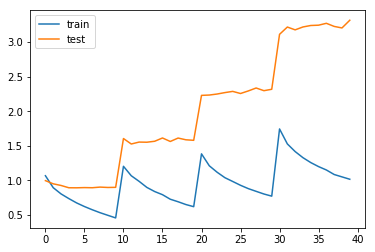

In [0]:
train_loop(range(6, 10))